# AirBNB in Singapore

This file aims to analyze the various Airbnb units in Singapore. 

We aim to investigate how the naming, location and other factors will affect the pricing strategy of an Airbnb unit.

We also want to build a model that predicts unit prices based on these factors.

### Import needed libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import scipy.sparse as sp
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Tze
[nltk_data]     Jet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tze
[nltk_data]     Jet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Tze
[nltk_data]     Jet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Import dataset

In [4]:
data = pd.read_csv('listings.csv')

### Clean data


#### A few columns are removed from the dataset as they do not contribute much.

- id: Not needed as it is used for identification only
- host_id, host_name: We are not interested in who the hosts are, just the listings
- Latitude and Longitude: Redundant information

In [5]:
# Remove entries that are unreasonably expensive
data = data[data['price'] < 1000]

data.drop(labels=['id', 'host_id', 'host_name'], axis=1, inplace=True)

data.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,COZICOMFORT LONG TERM STAY ROOM 2,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,Pleasant Room along Bukit Timah,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,COZICOMFORT,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,Ensuite Room (Room 1 & 2) near EXPO,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,B&B Room 1 near Airport & EXPO,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


#### Remove units with non-english names.

Future todo: Try to semantically analyze chinese units as wells

In [6]:
# Regular expression for matching Chinese characters
# This pattern matches any character in the specified Unicode ranges
chinese_regex_pattern = r'[\u4e00-\u9fff]'

# Convert 'name' column to string type
data['name'] = data['name'].astype(str)

# Filter out rows containing Chinese characters
data = data[~data['name'].str.contains(chinese_regex_pattern)]

data.head

<bound method NDFrame.head of                                                    name neighbourhood_group  \
0                     COZICOMFORT LONG TERM STAY ROOM 2        North Region   
1                       Pleasant Room along Bukit Timah      Central Region   
2                                           COZICOMFORT        North Region   
3                   Ensuite Room (Room 1 & 2) near EXPO         East Region   
4                       B&B  Room 1 near Airport & EXPO         East Region   
...                                                 ...                 ...   
7902  Loft 2 pax near Haw Par / Pasir Panjang. Free ...      Central Region   
7903                         3bedroom luxury at Orchard      Central Region   
7904    [ Farrer Park ] New City Fringe CBD Mins to MRT      Central Region   
7905          Cheap Master Room in Central of Singapore      Central Region   
7906  Amazing room with private bathroom walk to Orc...      Central Region   

     neighbourhood  l

## Visualization

### Plotting the relationship between each feature and the price of Airbnb unit

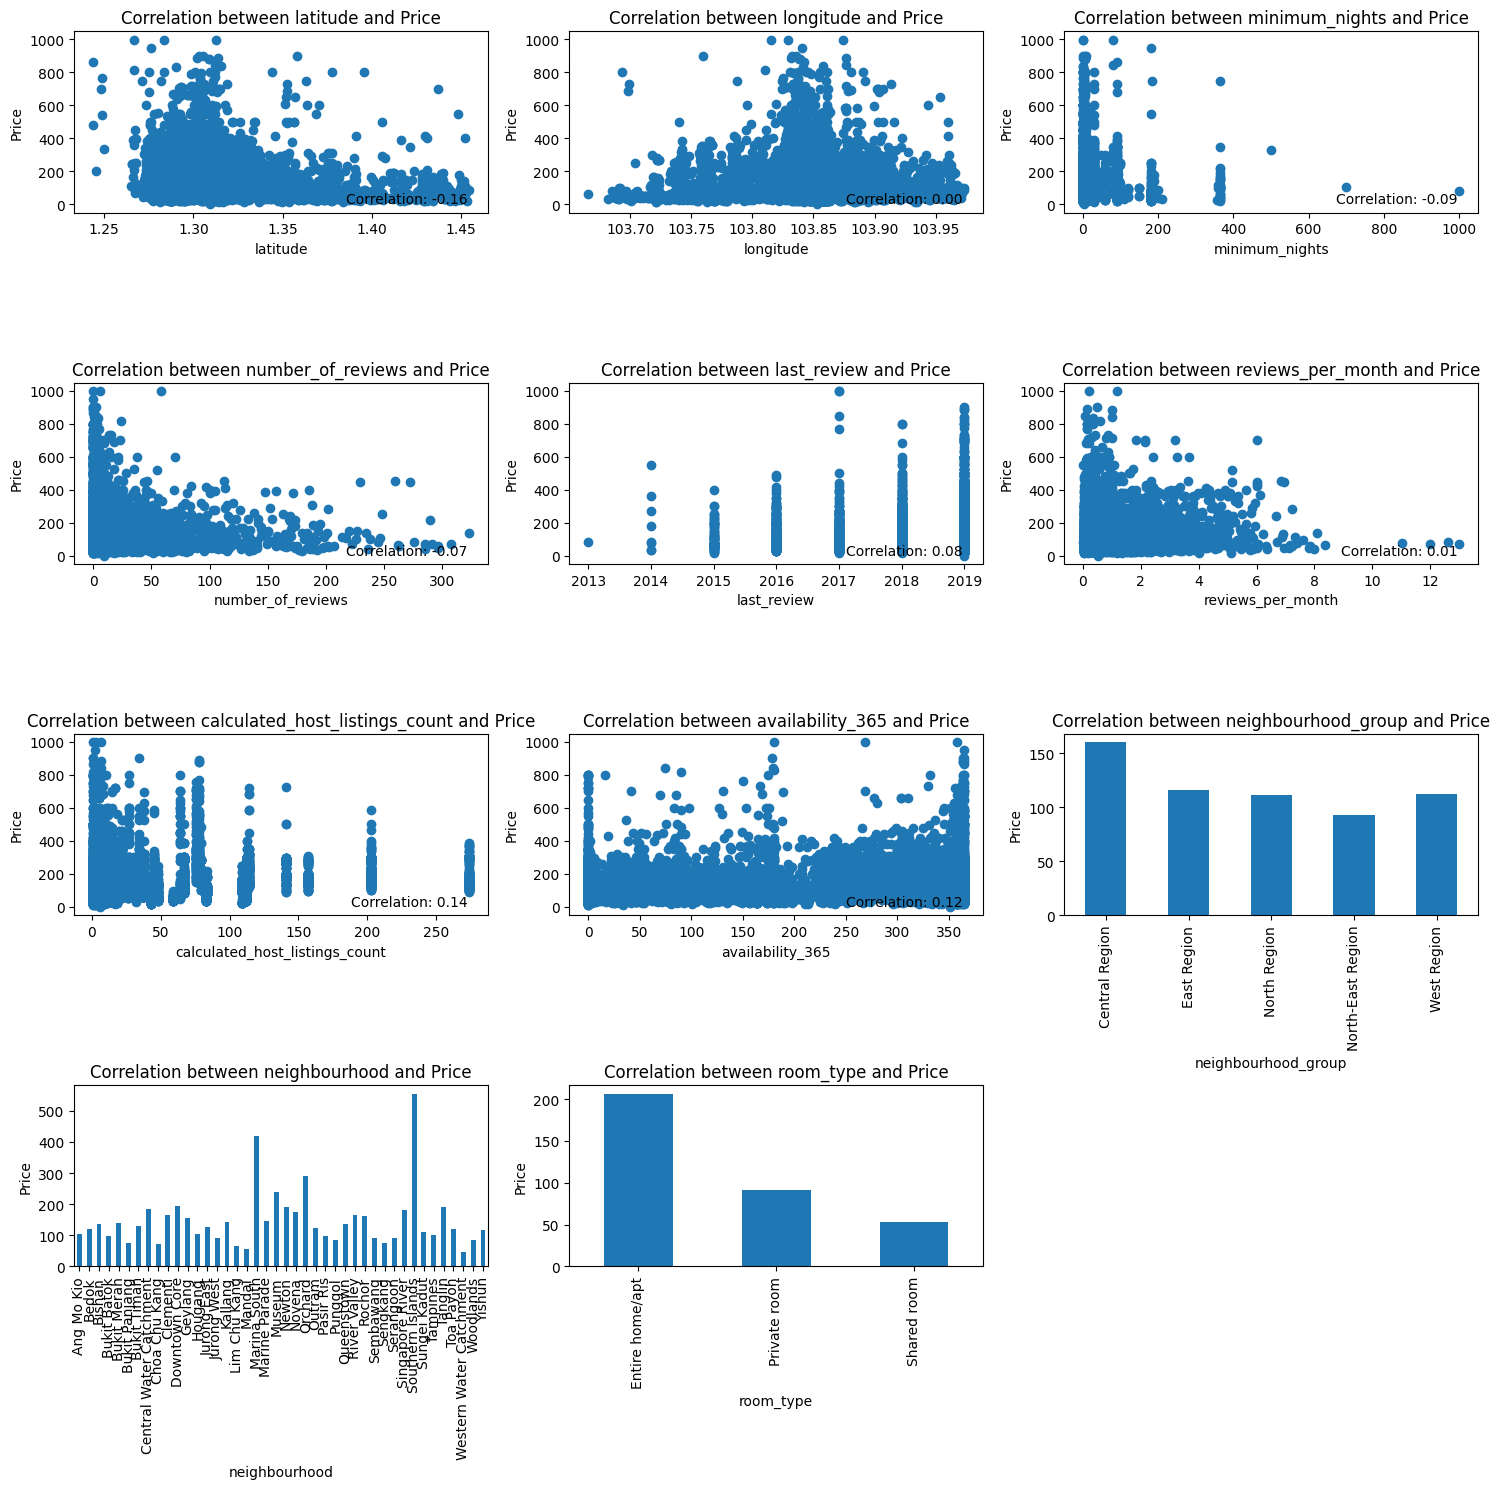

In [7]:
# Define the continuous and categorical features

data['last_review'] = pd.to_datetime(data['last_review']).dt.year

# Get the lists of features we want to plot
# Unit name is excluded since it is unique for each entry
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('name')
continuous_features = continuous_features.drop('price')
features = continuous_features.append(categorical_features)

num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols 
    ax = axes[row, col]

    if feature in continuous_features:
        # Plot scatterplot for continuous features
        ax.scatter(data[feature], data['price'])
        ax.set_xlabel(feature)
        ax.set_ylabel('Price')
        ax.set_title(f'Correlation between {feature} and Price')
        
        # Calculate correlation coefficient
        correlation = data[feature].corr(data['price'])
        ax.text(0.95, 0.05, f'Correlation: {correlation:.2f}', transform=ax.transAxes, ha='right')
        
    elif feature in categorical_features:
        # Plot bar plot for categorical features
        data.groupby(feature)['price'].mean().plot(kind='bar', ax=ax)
        ax.set_xlabel(feature)
        ax.set_ylabel('Price')
        ax.set_title(f'Correlation between {feature} and Price')
        ax.tick_params(axis='x', rotation=90)

for i in range(len(features), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

fig.tight_layout()
plt.show()


#### Which region has the most units?

<Axes: title={'center': 'Number of units in each region'}, xlabel='Region', ylabel='Number of units'>

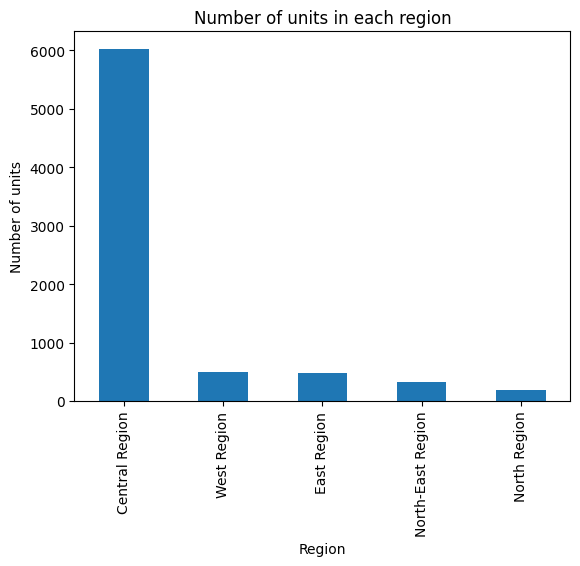

In [8]:
# which region has the most units?
region = data['neighbourhood_group'].value_counts()
region.plot(kind='bar', title='Number of units in each region', xlabel='Region', ylabel='Number of units')

#### What is the mean price for each region?

<Axes: title={'center': 'Mean price for each neighbourhood'}, xlabel='Neighbourhood', ylabel='Mean price'>

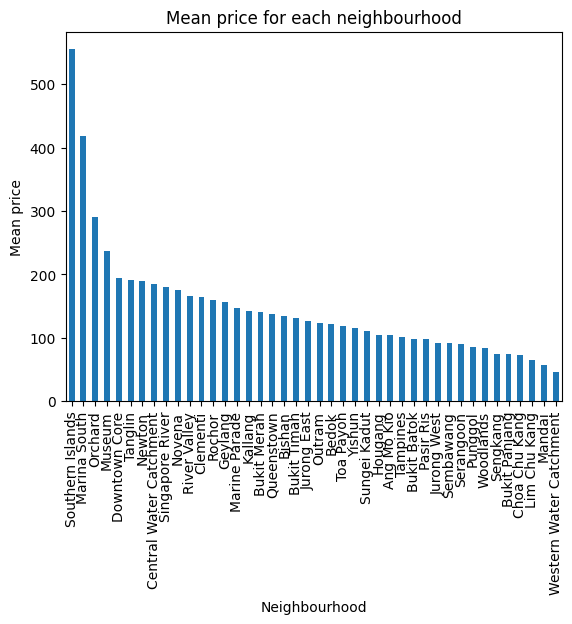

In [9]:
# Get the mean price for each neighbourhood
neighbourhoods = data.groupby('neighbourhood')['price'].mean()

# order the neighbourhoods by mean price
neighbourhoods = neighbourhoods.sort_values(ascending=False)
neighbourhoods.plot(kind='bar', title='Mean price for each neighbourhood', xlabel='Neighbourhood', ylabel='Mean price')

### Distribution of Airbnb Prices

<Axes: title={'center': 'Price distribution'}, xlabel='Price', ylabel='Number of units'>

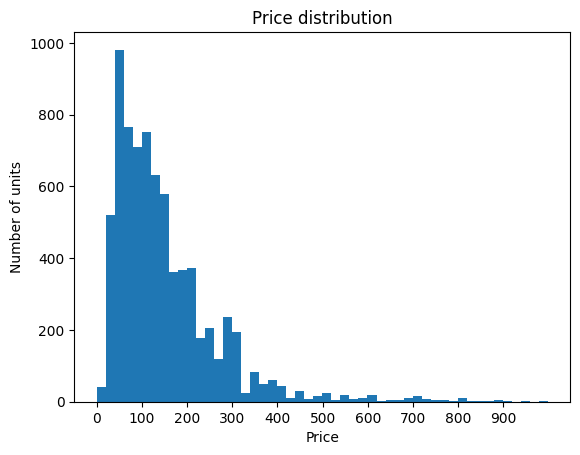

In [10]:
# histogram of prices with smaller bins
data['price'].plot(kind='hist', title='Price distribution', 
                   xlabel='Price', ylabel='Number of units', 
                   bins=50, xticks=range(0, 1000, 100))

### How does an Airbnb unit name affect pricing?

Would adding certain keywords (such as MRT, Orchard, etc.) cause an increase in the price of an Airbnb?

In [11]:
# This method tokenizes the unit name, cleans the text, and returns a list of words

def preprocess_text(text):
    # Tokenize
    words = nltk.word_tokenize(text)
    
    # Lower case
    words = [word.lower() for word in words if word.isalpha()]

    # Remove punctuation
    words = list(filter(lambda token: token not in string.punctuation, words))
    # print(words[:10])

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove short words
    words = [word for word in words if len(word) > 2]

    # Rejoin the words
    words = ' '.join(words)

    # print(words[:10])
    return words

data['clean_name'] = data['name'].apply(preprocess_text)

# print(data.head(10))
    

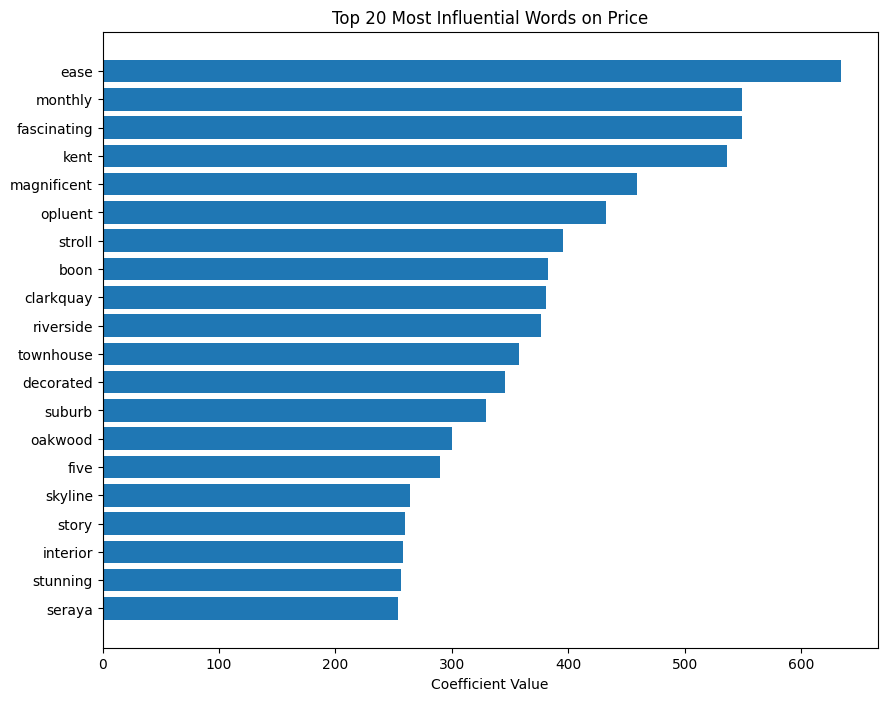

In [12]:
# Top 20 words that are most influential on price

tfidf_vectorizer = TfidfVectorizer(min_df=3)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['clean_name'])

model = LinearRegression()
model.fit(tfidf_matrix, data['price'])

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_
top_features_indices = coefficients.argsort()[-20:]
top_features_names = feature_names[top_features_indices]
top_coefficients = coefficients[top_features_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(20), top_coefficients, align='center')
plt.yticks(np.arange(20), top_features_names)
plt.xlabel('Coefficient Value')
plt.title('Top 20 Most Influential Words on Price')
plt.show()

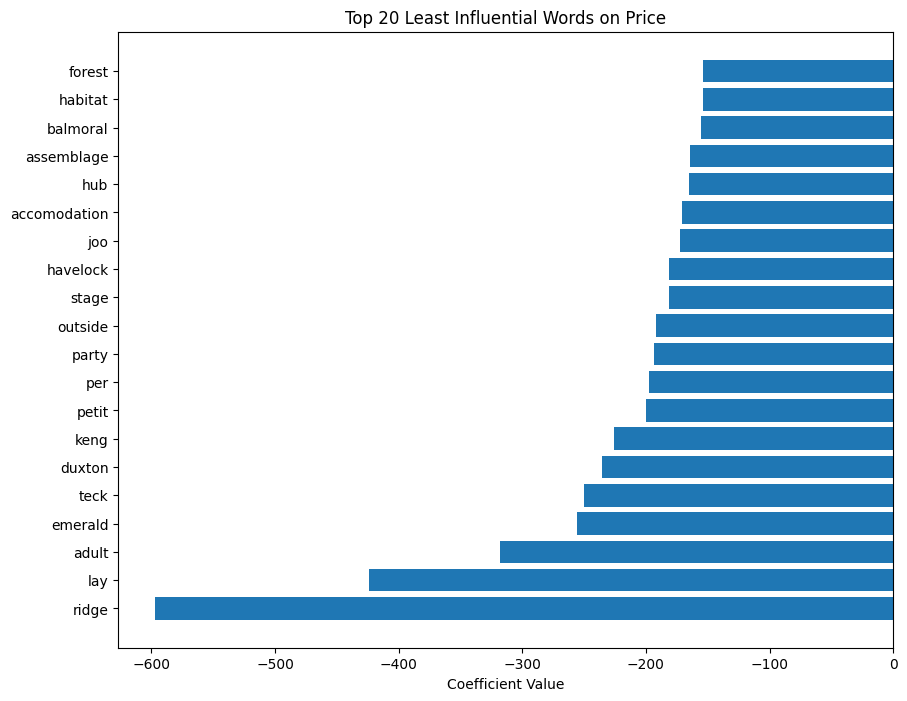

In [13]:
# Step 3: Extract Feature Importance
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_
top_features_indices = coefficients.argsort()[:20]  # Indices of bottom 20 features
top_features_names = feature_names[top_features_indices]
top_coefficients = coefficients[top_features_indices]

# Step 4: Visualize the Results
plt.figure(figsize=(10, 8))
plt.barh(range(20), top_coefficients, align='center')
plt.yticks(np.arange(20), top_features_names)
plt.xlabel('Coefficient Value')
plt.title('Top 20 Least Influential Words on Price')
plt.show()

### Average price for different room types

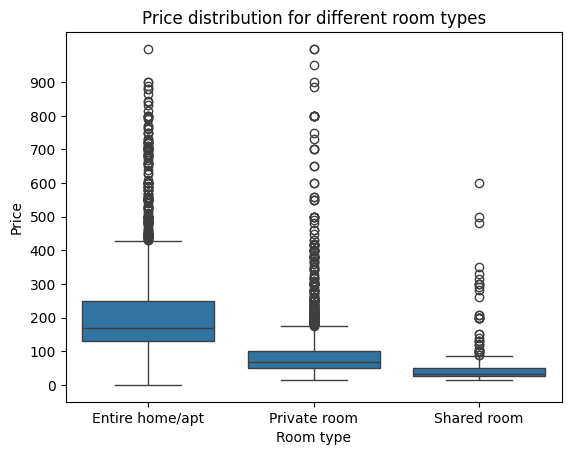

In [14]:
# group units into different room types, then do a box plot for each type of room
room_type = data.sort_values('room_type')
plot = sns.boxplot(x='room_type', y='price', data=room_type)
plot.set_title('Price distribution for different room types')
plot.set_xlabel('Room type')
plot.set_ylabel('Price')
plot.set_yticks(range(0, 1000, 100))

# Modelling

Given a unit, can we predict its price?

In [31]:
# Preprocess all data
data = pd.read_csv('listings.csv') 

# Drop data with little to no correlation, and not already dropped
# data = data.drop(labels=['id', 'host_id', 'host_name', 'minimum_nights', 'reviews_per_month', 'last_review', 'availability_365', 
#                          'calculated_host_listings_count', 'neighbourhood', 'name'], axis=1, errors='ignore')

data = data[['neighbourhood_group', 'room_type', 'price']]
data = pd.get_dummies(data, columns=['room_type', 'neighbourhood_group'])
data.head()

,price,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Central Region,neighbourhood_group_East Region,neighbourhood_group_North Region,neighbourhood_group_North-East Region,neighbourhood_group_West Region
0,83,False,True,False,False,False,True,False,False
1,81,False,True,False,True,False,False,False,False
2,69,False,True,False,False,False,True,False,False
3,206,False,True,False,False,True,False,False,False
4,94,False,True,False,False,True,False,False,False


Preparing the train and test data, then train the model

In [32]:
X = data.drop('price', axis=1) 
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# test 
y_pred = model.predict(X_test)
accuracy = mean_squared_error(y_test, y_pred)
print(accuracy)

52540.172867297064
